In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math

import requests
import json

In [3]:
#constants
weight = "PWGTP"
housing_identifier = "SERIALNO"
person_identifier = "SPORDER"
lim = "limiter"

In [4]:
def import_census_data(variables, target, year, limiters, ca_limit, drop): #acs data
  '''
  limiters: specified values to limit data requested
  '''

  vars = variables[:]

  base_request = "https://api.census.gov/data/" + year + "/acs/acs1/pums?get="
  base_request += weight + "," + target
  base_request += "," + housing_identifier + "," + person_identifier
  request = base_request

  #remove base vars
  vars.remove(target)
  vars.remove(weight)
  vars.remove(housing_identifier)
  vars.remove(person_identifier)

  for v in drop:
    vars.remove(v)

  dfs = []

  for i in range(len(limiters)):
    l = limiters[i]
    request += l

    if ca_limit:
      request += "&ucgid=0400000US06"

    #get target/weight/ids
    response = requests.get(request)
    json_data = json.dumps(response.json())
    df = pd.read_json(json_data)
    df = df.rename(columns=df.iloc[0]).loc[1:].reset_index()
    df = df[[target, weight, housing_identifier, person_identifier]]

    df[lim] = i

    dfs.append(df)

  data = pd.concat(dfs, ignore_index=True)

  target_col = data[target]
  weight_col = data[weight]
  housing_identifier_col = data[housing_identifier]
  person_identifier_col = data[person_identifier]
  lim_col = data[lim]

  #requesting all data
  curr = 0
  while curr < len(vars):
    data, curr = request_vars_and_merge(vars, data, base_request, limiters, target,
                                        4, curr, target_col, weight_col,
                                        housing_identifier_col, person_identifier_col,
                                        lim_col, ca_limit)

  data.drop(lim,axis=1,inplace=True)
  data.to_csv('/content/drive/My Drive/data.csv', index=False) #save to csv

  return data

In [5]:
def request_vars_and_merge(vars, df, base_request, limiters, target, num_vars, curr,
                           target_col, weight_col, housing_identifier_col,
                           person_identifier_col, lim_col, ca_limit):
  '''
  df: existing df
  base_request: request for weight, target, & identifiers
  limiter: any limiters on the data requested (e.g. state)
  target: target variable
  num_vars: vars in base_request
  target_col: target var data
  weight_col: weights
  housing_identifier_col: housing ids
  person_identifier_col: person ids within a household
  '''

  #get new vars
  new_df, curr = request_vars(vars, base_request, limiters, target, num_vars,
                              curr, weight_col, ca_limit)
  new_df.loc[:,target] = target_col
  new_df.loc[:,weight] = weight_col
  new_df.loc[:,housing_identifier] = housing_identifier_col
  new_df.loc[:,person_identifier] = person_identifier_col
  new_df.loc[:,lim] = lim_col

  #merge with existing df
  df = pd.merge(df, new_df, on=[housing_identifier, person_identifier, weight,
                                target, lim])
  df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

  return df, curr

In [6]:
def request_vars(vars, base_request, limiters, target, num_vars, curr,
                 weight_col, ca_limit):
  #request data
  request = base_request

  #create request
  while num_vars < 50 and curr < len(vars):
    request += ','+vars[curr]
    curr += 1
    num_vars += 1

  dfs = []

  for i in range(len(limiters)):
    l = limiters[i]
    curr_request = request+ l

    if ca_limit:
      curr_request += "&ucgid=0400000US06"

    #get target/weight/ids
    response = requests.get(curr_request)
    json_data = json.dumps(response.json())
    df = pd.read_json(json_data)
    df = df.rename(columns=df.iloc[0]).loc[1:].reset_index(drop=True)

    df[lim] = i

    dfs.append(df)

  new_df = pd.concat(dfs, ignore_index=True)

  #there are no missing values, checked with print(new_df.isna().sum())

  #drop identifiers
  new_df.drop([housing_identifier, person_identifier, lim],axis=1,inplace=True)

  #converting N (meaning N/A) to 0, have individually checked each var to confirm this is true
  new_df.replace('N', 0, inplace = True)

  #indp = based on industry codes, naicsp = based on NAICS codes (indp is
  #derived from naicsp and is less detailed to protect individual respondents)
  #indp also has higher correlation with income so choosing to keep indp over naicsp
  if "NAICSP" in new_df.columns:
    new_df.drop("NAICSP", axis=1, inplace=True)

  #only one unique value, don't need
  if "ADJINC" in new_df.columns:
    new_df.drop("ADJINC", axis=1, inplace=True)
  if "ADJHSG" in new_df.columns:
    new_df.drop("ADJHSG", axis=1, inplace=True)

  #recode SOCP
  if "SOCP" in new_df.columns:
    new_df["SOCP"] = recode(new_df, "SOCP")

  new_df = new_df.astype(int)

  #pearson correlation coefficient analysis w target (PINCP)
  threshold = 0.2
  correlations = target_corr(new_df, target, weight)
  features = correlations[correlations>=threshold]
  print("selected features:")
  print(features)

  #fod1p/fod2p have same info but fod2p doesn't have a high enough correlation so already dropped

  #filter new_df
  new_df = new_df[features.index]
  return new_df, curr

In [7]:
def recode(df, col):
  '''
  returns recoded col
  '''
  unique = dict(enumerate(df[col].unique()))
  unique = dict([(value, key) for key, value in unique.items()])
  return df[col].replace(unique)

In [8]:
def mean(x, w):
  '''weighted mean'''
  return np.sum(x.astype(int) * w) / np.sum(w)

def cov(x, y, w):
  '''weighted covariance'''
  return np.sum(w * (x.astype(int) - int(mean(x, w))) * (y - mean(y, w))) / np.sum(w)

def corr(x, y, w):
  '''weighted correlation'''
  cov_xy = cov(x, y, w)
  cov_xx = cov(x, x, w)
  cov_yy = cov(y, y, w)

  if np.isclose(cov_xx, 0.0) or np.isclose(cov_yy, 0.0):
    #for some categorical & characteristics that are the same for everyone
    #(e.g. state if called with ca_limit = True)
    print(x)
    return 0.0

  result = cov_xy / np.sqrt(cov_xx * cov_yy)
  return result

def target_corr(df, target, weight):
  '''
  returns new df with index as col names and value as correlation with target
  '''
  cols = df.columns
  cols = cols.drop([target, weight])

  l = len(cols)-1
  w = df[weight].astype(int)

  results = []
  for col in cols:
    results.append(corr(df[col], df[target], df[weight]))

  results = pd.DataFrame(results, index = cols, columns=["corr"])

  results = results["corr"].sort_values(ascending=False)[1:]
  return results

In [9]:
curr_vars = ["PINCP", "PWGTP", "SERIALNO", "HHLDRAGEP", "SSIP", "ELEP", "RAC2P",
             "RAC3P", "RAC1P", "RACNUM", "WATP", "MHP", "RETP", "SSP", "HINCP",
             "RMSP", "INTP", "SEMP", "SMP", "PERNP", "PAP", "GASP", "WKWN",
             "WAGP", "FULP", "SMOCP", "FINCP", "OIP", "TAXAMT", "CONP",
             "INSP", "OCPIP", "GRNTP", "MRGP", "VALP", "BDSP", "NOC", "NP",
             "NRC", "SPORDER", "NPF", "RNTP", "WKHP", "POVPIP", "GRPIP",
             "JWMNP", "AGEP", "ADJHSG", "ADJINC", "MV", "FPARC", "DRIVESP",
             "RACSOR", "NATIVITY", "JWAP", "HICOV", "PRIVCOV", "R60",
             "RELSHIPP", "VACDUR", "MLPIK", "PLM", "VPS", "DEAR", "R18", "MLPJ",
             "GCL", "STOV", "TEL", "ELEFP", "WATFP", "YOEP", "SMX", "OTHSVCEX",
             "MLPCD", "ANC2P", "FHINS4C", "WRK", "POBP", "RACAIAN", "LAPTOP",
             "HHT2", "MLPFG", "FOD1P", "FOD2P", "SMARTPHONE", "NAICSP", "INDP",
             "WAOB", "SOCP", "GASFP", "HIMRKS", "FHINS3C", "FHINS5C",
             "ACCESSINET", "HOTWAT", "NWLA", "CITWP", "JWTRNS", "REFR", "PSF",
             "DECADE", "PUBCOV", "FULFP", "MRGT", "VACOTH", "BROADBND", "LANP",
             "ANC1P", "TEN", "POWPUMA", "HISPEED", "PLMPRP", "CPLT", "YRBLT",
             "DRAT", "NR", "MRGX", "HINS7", "MARHYP", "COMPOTHX", "SINK",
             "MARHT", "SATELLITE", "WIF", "HISP", "MAR", "SCHL", "NWLK", "DPHY",
             "DEYE", "MIGSP", "HHLANP", "PARTNER", "RACNH", "WKL", "VEH",
             "DDRS", "MIGPUMA", "LNGI", "HINS2", "QTRBIR", "SFN", "RACBLK",
             "MLPH", "ESR", "NPP", "DIS", "DIALUP", "HHLDRRAC1P", "TABLET",
             "MLPB", "DOUT", "SCH", "RACPI", "POWSP", "ANC", "MIL", "OC",
             "HUGCL", "RWAT", "HHLDRHISP", "HINS3", "RESMODE", "MARHW", "SFR",
             "ESP", "RACASN", "HINS5", "MLPE", "OCCP", "MARHD", "SCHG", "MRGI",
             "MIG", "HINS1", "MSP", "FER", "MULTG", "WORKSTAT", "MARHM", "KIT",
             "GCR", "HUPARC", "HINS6", "GCM", "ACR", "HINS4", "PAOC", "RNTM",
             "DRATX", "FS", "SVAL", "RACWHT", "NWAB", "HUPAOC", "R65", "RC",
             "BATH", "SEX", "HFL", "WKEXREL", "VACS", "HHL", "SRNT", "NWAV",
             "NWRE", "BLD", "LANX", "MLPA", "HHT", "DREM", "COW", "HUPAC",
             "CIT", "AGS", "ENG", "JWRIP", "JWDP", "NOP"]

## question 1
### for the aapi community, does disaggregating data by ethnicity or by region rather than just by race (aapi + aa/pi) lead to better predictions of someone’s income?

In [10]:
limiters = ["&RACPI=1&RACASN=1", "&RACPI=0&RACASN=1", "&RACPI=1&RACASN=0"] #all aapi
drop = ["RACPI", "RACASN"]
#limiters = ["&RACPI=1&RACASN=1", "&RACPI=1&RACASN=0"] #mixed + pi
data = import_census_data(curr_vars, "PINCP", "2021", limiters, True, drop)

0        6
1        6
2        6
3        6
4        6
        ..
79186    6
79187    6
79188    6
79189    6
79190    6
Name: ST, Length: 79191, dtype: int64
selected features:
WAGP      0.918188
WKHP      0.542990
WKWN      0.528609
HINCP     0.467163
INTP      0.386412
FINCP     0.337600
POVPIP    0.335686
SEMP      0.306281
AGEP      0.258930
JWMNP     0.204650
Name: corr, dtype: float64
0        0
1        0
2        0
3        0
4        0
        ..
79186    0
79187    0
79188    0
79189    0
79190    0
Name: VACDUR, Length: 79191, dtype: int64
0        6
1        6
2        6
3        6
4        6
        ..
79186    6
79187    6
79188    6
79189    6
79190    6
Name: ST, Length: 79191, dtype: int64
selected features:
INDP     0.363757
FOD1P    0.360684
SOCP     0.285873
JWAP     0.219428
Name: corr, dtype: float64
0        0
1        0
2        0
3        0
4        0
        ..
79186    0
79187    0
79188    0
79189    0
79190    0
Name: VACOTH, Length: 79191, dtype: int64
0 

In [11]:
def request_data(request, limiters):
  dfs = []

  for l in limiters:
    response = requests.get(request+l)
    json_data = json.dumps(response.json())
    df = pd.read_json(json_data)
    df = df.rename(columns=df.iloc[0]).loc[1:].reset_index()
    dfs.append(df)

  return pd.concat(dfs, ignore_index=True)

In [12]:
print(data.columns)

Index(['PINCP', 'PWGTP', 'SERIALNO', 'SPORDER', 'WAGP', 'WKHP', 'WKWN',
       'HINCP', 'INTP', 'FINCP', 'POVPIP', 'SEMP', 'AGEP', 'JWMNP', 'INDP',
       'FOD1P', 'SOCP', 'JWAP', 'NWLA', 'SCHL', 'POWPUMA', 'JWTRNS', 'MARHYP',
       'MARHT', 'MIL', 'MARHW', 'MARHD', 'MARHM', 'POWSP', 'HINS4', 'NWAV',
       'NWRE', 'JWDP', 'COW'],
      dtype='object')


In [13]:
def print_unique_vals(df, vars):
  for col in vars:
    print("col")
    print(df[col].value_counts())

In [14]:
#understanding how race vars are determined for someone who is chinese & indian
df = request_data("https://api.census.gov/data/2021/acs/acs1/pums?get=PWGTP," +
                  "SERIALNO,SPORDER,RAC1P,RAC2P,RAC3P,RACBLK",
                   ["&ANC1P=706&ANC2P=615", "&ANC1P=615&ANC2P=706"])
print(df)
print_unique_vals(df, ["RAC1P", "RAC2P", "RAC3P", "RACBLK"])
print(df[df["RACBLK"]=="1"])
print_unique_vals(df[df["RACBLK"]=="1"], ["RAC1P", "RAC2P", "RAC3P"])

    index PWGTP       SERIALNO SPORDER RAC1P RAC2P RAC3P RACBLK ANC1P ANC2P
0       1    46  2021HU0982443       1     6    59   076      0   706   615
1       2    45  2021HU0985474       3     6    59   076      0   706   615
2       3    39  2021HU0985474       4     6    59   076      0   706   615
3       4    54  2021HU1004233       2     6    59   076      0   706   615
4       5    86  2021HU1031909       3     6    59   076      0   706   615
..    ...   ...            ...     ...   ...   ...   ...    ...   ...   ...
89     47    79  2021HU0674612       2     9    68   086      0   615   706
90     48   273  2021HU0741053       3     6    59   076      0   615   706
91     49   176  2021HU0814116       2     6    59   076      0   615   706
92     50    50  2021HU0822980       1     9    68   031      1   615   706
93     51    42  2021HU0822980       2     9    68   031      1   615   706

[94 rows x 10 columns]
col
6    59
9    32
2     3
Name: RAC1P, dtype: int64
col
59    

In [15]:
#looking at "mixture" ancestry -- all other ancestry values are single ethnicity
df = request_data("https://api.census.gov/data/2021/acs/acs1/pums?get=PWGTP," +
                  "SERIALNO,SPORDER,RAC1P,RAC2P,RAC3P",
                   ["&ANC1P=995", "&ANC2P=995"])
print_unique_vals(df, ["RAC1P", "RAC2P", "RAC3P"])
print(df)

col
9    8433
1    7669
8    1783
2     261
6      45
3      33
7      11
5       9
Name: RAC1P, dtype: int64
col
68    8433
01    7669
67    1783
02     261
38      11
45      11
05       8
16       7
29       6
27       6
63       5
43       5
57       5
58       4
59       4
28       4
61       3
37       3
60       2
48       2
17       2
36       2
49       1
42       1
62       1
03       1
24       1
09       1
11       1
53       1
Name: RAC2P, dtype: int64
col
001    7669
029    6912
015    1783
016     469
017     283
       ... 
008       1
089       1
052       1
076       1
048       1
Name: RAC3P, Length: 76, dtype: int64
       index PWGTP       SERIALNO SPORDER RAC1P RAC2P RAC3P ANC1P ANC2P
0          1    32  2021GQ0000841       1     8    67   015   995   NaN
1          2    81  2021GQ0001207       1     8    67   015   995   NaN
2          3    58  2021GQ0001511       1     9    68   029   995   NaN
3          4    44  2021GQ0001719       1     8    67   015   995   

In [16]:
#checking relationship between specific RAC3P (ethnicity) values + income
df = request_data("https://api.census.gov/data/2021/acs/acs1/pums?get=PWGTP,PINCP,SERIALNO,SPORDER&RAC3P=004&RAC3P=006&RAC3P=013",[""])
df.drop([housing_identifier, person_identifier],axis=1,inplace=True)
df = df.astype('int32')

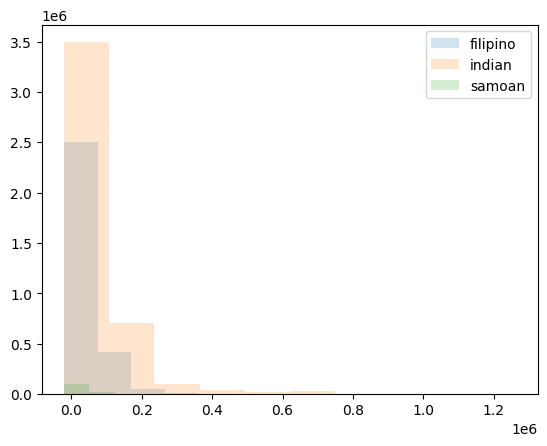

In [17]:
#histogram
unique = df['RAC3P'].unique()
ethnicities = {6:"filipino",4:"indian",13:"samoan"}

for val in unique:
  new_df = df[df["RAC3P"] == val]
  plt.hist(new_df["PINCP"], weights=new_df["PWGTP"], label=ethnicities[val],alpha=.2)

plt.legend(loc='upper right')
plt.show()

## question 2

### is it possible to predict race (and potentially, region ethnicity etc) given certain features so even if you don’t give a model race data, can it extrapolate it and build its own stereotypes?

In [ ]:
#predict race

#try both (1) feature selection again and (2) q1 dataset but diff output
data = import_census_data(curr_vars, "RAC1P", "2021", limiters, True, []) #ca_limit = True